# MNIST Sequence Classification 

In this Task the MNIST Sequence Dataset is used(see https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/wiki/MNIST-digits-stroke-sequence-data) to train a sequence Classifier. The dataset consists of sequences generated from the famous MNIST dataset. Based on this sequences our Model has to classify the correct number the sequence represents. To process and classify this sequence a RNN is used.

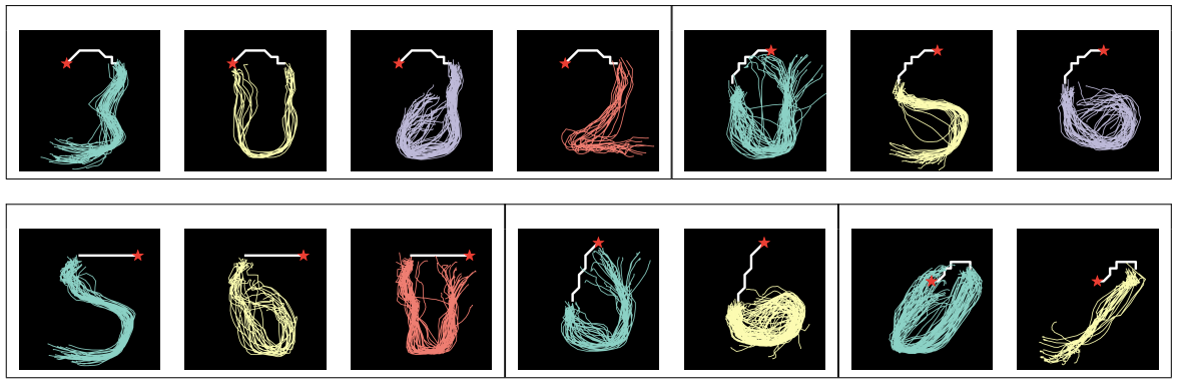

This Tutorial is based on the PyTorch introduction Tutorials (https://pytorch.org/tutorials/)

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from download import download_file_from_google_drive
from common import load_data

## Set Parameter

In [6]:
# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2
num_train = int((1 - test_size) * num_datapoints)

# Network params
input_size = 2
hidden_layer = 128
output_dim = 10
num_layers = 2
num_epochs = 500
dtype = torch.float
input_seq = 100
pred_length = 1
batch_size = 32
train_samples = 10
test_samples = 100

## Load data
The loading and preprocessing is based on the implementation of https://github.com/edwin-de-jong/incremental-sequence-learning.

The Data is Downlaoded as numpy files from my personal Google Drive. 
Numpy Data available at https://drive.google.com/file/d/1uaVImXWqdbEhj9euCw8EMKJKsJ7uS7I2/view?usp=sharing

If not possible the Dataset can also be downloaded from https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/raw/master/sequences.tar.gz, extracted and processed by load_data().

In [7]:
file_id = '1XHWS4PqmnMaR2pID0bPsVtVeohZpKgTF'
destination = './extracted_data_label.npz'
download_file_from_google_drive(file_id, destination)
        
def prepare_data_label(data, label, train=True):
    if train:
        x = data[0:60000, 0:input_seq, :]
        y = label[0:60000, :]
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
        return (x, y)
    else:
        x = data[60000:, 0:input_seq, :]
        y = label[60000:, :]
        x = x[0:int(x.shape[0] / batch_size) * batch_size, :]
        y = y[0:int(x.shape[0] / batch_size) * batch_size, :]
        return (x, y)

data, label = load_data()
(x_data, y_data) = prepare_data_label(data, label, train=True)
(x_data_test, y_data_test) = prepare_data_label(data, label, train=False)

output_seq = y_data.shape[1]
print(x_data.shape)
print(y_data.shape)

(60000, 100, 2)
(60000, 1)


Simple Class to sample random batches from the training data 

In [8]:
class BatchGenerator(object):
    def __init__(self, data_x, data_y, batch_size=batch_size, output_seq=output_seq, n_action=2):
        self.data_x = data_x
        self.data_y = data_y
        self.batch_size = batch_size
        self.output_seq = output_seq
        self.n_action = n_action

    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        indices = np.random.randint(0, len(self.data_x), batch_size)
        x_batch = torch.tensor(self.data_x[indices, :, :]).to(torch.float)
        y_batch = torch.tensor(self.data_y[indices, :]).squeeze(1).to(torch.long)
        return x_batch, y_batch

## Build Model

For this task a simple RNN which processes an input together with the hidden state through a linear layer is used. The hidden state is also computed by a linear layer. To compute the probability for a class label (0-10 for MNIST) we use a Softmax layer at the output. 
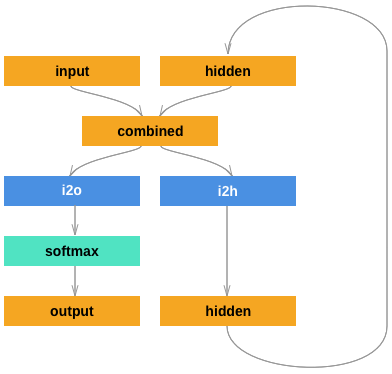
The output of the hidden layer is passed back into the model for each time step. Note that PyTorch takes car of the hidden states and the corresponding gradients. Hence a RNN can be implemented like a normal feed forward network. 

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.batch_size, self.hidden_size)

rnn = RNN(input_size, hidden_layer, batch_size, output_dim)
train_data_generator = BatchGenerator(x_data, y_data, batch_size=batch_size)
test_data_generator = BatchGenerator(x_data_test, y_data_test, batch_size=batch_size)

### Test Model

Let's test the model by passing in two sequence steps of the first sample in a generated batch. The highest output value corresponds to the predicted class. 

In [10]:
x_batch, y_batch = train_data_generator.sample()
print(x_batch.shape)

# hidden Layer initialization
hidden = torch.zeros(1, hidden_layer).to(torch.float)

in_sample = x_batch[0, 0, :].unsqueeze(0)
output, next_hidden = rnn(in_sample, hidden)
print(output)

in_sample = x_batch[0, 1, :].unsqueeze(0)
output, next_hidden = rnn(in_sample, next_hidden)
print(output)

torch.Size([32, 100, 2])
tensor([[-2.1101, -3.5716, -2.4679, -2.9197, -2.7238, -1.7236, -1.6601, -2.7064,
         -2.2194, -2.2794]], grad_fn=<LogSoftmaxBackward>)
tensor([[-2.2607, -3.3950, -1.7113, -3.1146, -3.1604, -2.0007, -1.5990, -3.0767,
         -2.3047, -2.1937]], grad_fn=<LogSoftmaxBackward>)


## Train Function  

To optimize the RNN we use a train function which gets called at for each new batch. In the loop we process each point from the sequnce and compute the output and the hidden state of our model. The last output is used as the class estimate. Since we train the model to classify the correct number based on the sequence we can use the NLLLoss. 

for prediction we do the same as in training just without the optimization. Hence, we also don't need any gradient. 

In [18]:
loss_fn = torch.nn.NLLLoss()
learning_rate = 5e-4
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(x_tensor, y_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(x_tensor.size()[1]):
        input_tensor = x_tensor[:, i, :]
        output, hidden = rnn(input_tensor, hidden)

    loss = loss_fn(output, y_tensor)

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    return output, loss.item()


def predict(x_tensor, y_tensor, test_size):
    with torch.no_grad():
        hidden = torch.zeros(test_size, hidden_layer).to(torch.float)

        for i in range(x_tensor.size()[1]):
            input_tensor = x_tensor[:, i, :]
            output, hidden = rnn(input_tensor, hidden)

        loss = loss_fn(output, y_tensor)
    predictions = np.argmax(output.cpu().numpy(), axis=1)
    correct_predictions = (predictions == y_tensor.cpu().numpy()).astype(int)
    acc = np.mean(correct_predictions)
    return loss.item(), acc

## Train Model

Now we can train the model for n_iters optimization steps. Also the training and test loss is recorded to monitor the training process. 

In [19]:
import time
import math

n_iters = 20000
plot_every = 100
test_size = 2048

# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_test_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    x_batch, y_batch = train_data_generator.sample()
    # category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(x_batch, y_batch)
    current_loss += loss

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        print("current_loss: ", current_loss/plot_every)
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        # test_loss
        x_test_batch, y_test_batch = test_data_generator.sample(batch_size=test_size)
        test_loss, accuracy = predict(x_test_batch, y_test_batch, test_size)
        print("current_test_loss: ", test_loss)
        print("current_test_accuracy: ", accuracy)
        all_test_losses.append(test_loss)

current_loss:  15.792415270805359
current_test_loss:  13.665740966796875
current_loss:  18.779284076690672
current_test_loss:  9.290006637573242
current_loss:  8.580991374254227
current_test_loss:  7.327641487121582
current_loss:  6.668013379573822
current_test_loss:  5.5199151039123535
current_loss:  4.442737505435944
current_test_loss:  4.1525373458862305
current_loss:  3.888294370174408
current_test_loss:  4.270051956176758
current_loss:  3.3565750336647033
current_test_loss:  3.6321611404418945
current_loss:  2.8991731715202333
current_test_loss:  2.7232325077056885
current_loss:  2.363468704223633
current_test_loss:  2.043994188308716
current_loss:  1.901738691329956
current_test_loss:  1.8412654399871826
current_loss:  1.7952604627609252
current_test_loss:  1.8340685367584229
current_loss:  1.7968754827976228
current_test_loss:  1.8726400136947632
current_loss:  1.7027635502815246
current_test_loss:  1.6815760135650635
current_loss:  1.7334135043621064
current_test_loss:  1.66760

## Plot Results 

Lastly let's plot the loss which was recorded during the training of the model. 

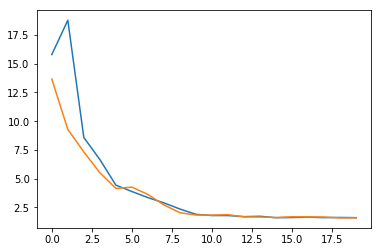

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(all_test_losses)